In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
from datetime import datetime, timedelta, date
%matplotlib inline

# Find most negative Feeds

## Intoroduction:

The objective of this analysis is to extract useful information from a dataset of feedback using sentiment analysis. 

Specifically, we will use the NLTK sentiment analyzer to classify feedback as positive, negative, or neutral, based on the sentiment expressed in the text.

To begin, we filtered the dataset to only include Tweets and used regular expressions to extract the relevant text from the "description" column. 

We then performed preprocessing steps such as removing punctuation and stop words, as well as applying stemming to the text.

The NLTK sentiment analyzer was then used to classify the feedback into positive, negative, or neutral categories. Finally, we utilized various visualization tools to analyze the results.

## Methodology:

The dataset was loaded using Pandas, and the relevant information was extracted using regular expressions.

The NLTK sentiment analyzer was used to classify feedback based on its sentiment.

The data was preprocessed using various techniques, including stop word removal and stemming.

## Load Data

In [2]:
df_0= pd.read_csv("/Users/waleedidrees/Dropbox/Python_Projects/My_Projects/data_wrangle/text_data.csv", index_col=0)
df_0.head()

,id,description,subject,created_at
0,471307,**First Name:\nRobert**\n\n**Email Address:\nb...,Please Cancel My Booking,2022-01-01 00:01:01.0000000 +00:00
1,471308,"Dear Barbara,\n\n\nThank you for your enquiry,...",Test Results,2022-01-01 00:02:10.0000000 +00:00
2,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07.0000000 +00:00
3,471310,"Dear Team,\n\nThe below customer was resulted ...",Customer Retest - Indeterminate,2022-01-01 00:06:53.0000000 +00:00
4,471311,"Dear Twaku,\n\n\nThank you for your enquiry, f...",test results,2022-01-01 00:08:08.0000000 +00:00


## Filter data only with Tweets
## Convert data to datetime format and rename columsn

In [3]:
df = (
    df_0.copy()
    .query("subject == 'Make a complaint' ")
    .rename(columns={'created_at':'created','via_source_from_address':'email_from'})
    .assign(
    created = lambda df_: pd.to_datetime(df_.created),
    date = lambda df_: df_.created.dt.date
    ).reset_index(drop=True)
    )
df.head()

,id,description,subject,created,date
0,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07+00:00,2022-01-01
1,471317,**First Name:\nRobert**\n\n**Last Name:\nThoma...,Make a complaint,2022-01-01 00:17:24+00:00,2022-01-01
2,471336,**First Name:\nJayne**\n\n**Last Name:\nReitze...,Make a complaint,2022-01-01 00:49:50+00:00,2022-01-01
3,471409,**First Name:\nDavid**\n\n**Last Name:\nPage**...,Make a complaint,2022-01-01 04:37:52+00:00,2022-01-01
4,471455,**First Name:\nElizabeth**\n\n**Last Name:\nDu...,Make a complaint,2022-01-01 07:19:00+00:00,2022-01-01


## Descriptive stats

we see that we have 3300 records and min date is 1st of january and max is 20th of january 2022

In [4]:
df.describe(include="all", datetime_is_numeric= True)

,id,description,subject,created,date
count,3300.000000,3300,3300,3300,3300
unique,NaN,3275,1,NaN,30
top,NaN,**First Name:\nAdebayo**\n\n**Last Name:\nJaco...,Make a complaint,NaN,2022-01-06
freq,NaN,18,3300,NaN,209
mean,500952.343030,NaN,NaN,2022-01-14 01:15:39.786363392+00:00,NaN
min,471309.000000,NaN,NaN,2022-01-01 00:04:07+00:00,NaN
25%,489186.000000,NaN,NaN,2022-01-06 15:03:04.249999872+00:00,NaN
50%,501749.000000,NaN,NaN,2022-01-12 16:36:45+00:00,NaN
75%,513401.500000,NaN,NaN,2022-01-20 16:22:27.249999872+00:00,NaN
max,526713.000000,NaN,NaN,2022-01-30 23:34:27+00:00,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   id           3300 non-null   int64              
 1   description  3300 non-null   object             
 2   subject      3300 non-null   object             
 3   created      3300 non-null   datetime64[ns, UTC]
 4   date         3300 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 129.0+ KB


## Extract Data from description column

### The description column contains all the useful information that we need to extract
### We can extract:
* email address
* Mobile number 
* Nature of issue 
* Main body of the email
* cpt_pk number
* First Name
* Last Name
however for this excercise we only need the main body of the emailand nature of issue.

In [6]:
strings= df.description
strings[11][210:]

'**Please share any more details that are relevant to your case:\nHi, I paid for my test £238 on 31st December at 5.25 pm, the money was taken and the booking was not made. I now need a refund so I can make a new test. Please do this immediately**'

## We will use regex to extract info before and after a pattern 
we can see in the example string above that the main body is after a pattern '**Please share any more details that are relevant to your case:\n'

we will use following regex to extract the information we need:

'(?<=\*\*Please share any more details that are relevant to your case:\n)(.*?)(?=\*\*)' 

* (?<=\n\*\*Please share any more details that are relevant to your case:\n) match pattern and gives location of everything after pattern
* (?=\*\*)' mathces pattern and gives location of everything before the pattern
* (.*?) and present all text between two anchors

### get main body of email

In [7]:
import re

search_pat=re.compile(r'(?<=\*\*Please share any more details that are relevant to your case:\n)(.*?)(?=\*\*)')
ar_body=[]
ac=[]
for string in strings:
    ac=search_pat.search(string)        
    if ac == None :
        ac_group = 'None'
    else: 
        ac_group = ac.group()
    #print(ac)
    ar_body.append(ac_group)     
df['body'] = ar_body
df.head()

,id,description,subject,created,date,body
0,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07+00:00,2022-01-01,"Hello, this is in reference to cancellation (E..."
1,471317,**First Name:\nRobert**\n\n**Last Name:\nThoma...,Make a complaint,2022-01-01 00:17:24+00:00,2022-01-01,The booking reference above with an S in front...
2,471336,**First Name:\nJayne**\n\n**Last Name:\nReitze...,Make a complaint,2022-01-01 00:49:50+00:00,2022-01-01,Absolutely disgusted with your staff arrived a...
3,471409,**First Name:\nDavid**\n\n**Last Name:\nPage**...,Make a complaint,2022-01-01 04:37:52+00:00,2022-01-01,The context of this is moving back to the UK h...
4,471455,**First Name:\nElizabeth**\n\n**Last Name:\nDu...,Make a complaint,2022-01-01 07:19:00+00:00,2022-01-01,No passenger locator form reference ID availab...


### Get the nature of issue

In [8]:
search_pat=re.compile(r'(?<=\*\*What is the nature of your issue\?:\n)(.*?)(?=\*\*)')

ac = []
ar_issue=[]
for string in strings:
    ac=search_pat.search(string)
    if ac == None:
        ac_group = 'None'
    else:
        ac_group = ac.group()    
    
    ar_issue.append(ac_group) 
df['issue'] = ar_issue
df.head()

,id,description,subject,created,date,body,issue
0,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07+00:00,2022-01-01,"Hello, this is in reference to cancellation (E...",Other
1,471317,**First Name:\nRobert**\n\n**Last Name:\nThoma...,Make a complaint,2022-01-01 00:17:24+00:00,2022-01-01,The booking reference above with an S in front...,Issues with booking
2,471336,**First Name:\nJayne**\n\n**Last Name:\nReitze...,Make a complaint,2022-01-01 00:49:50+00:00,2022-01-01,Absolutely disgusted with your staff arrived a...,Other
3,471409,**First Name:\nDavid**\n\n**Last Name:\nPage**...,Make a complaint,2022-01-01 04:37:52+00:00,2022-01-01,The context of this is moving back to the UK h...,Issues with booking
4,471455,**First Name:\nElizabeth**\n\n**Last Name:\nDu...,Make a complaint,2022-01-01 07:19:00+00:00,2022-01-01,No passenger locator form reference ID availab...,Issues with booking


##  PreProcessing Email body data

### Replace all numbers from email body
find any symbols and digits other than alphabets and replace with space.

In [9]:
df['body_1'] = df.body.str.replace(r'\d+', " ", regex=True)
df['body_1'] = df.body_1.str.replace('[^a-zA-Z]', " ", regex=True)
df.head(2)

,id,description,subject,created,date,body,issue,body_1
0,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07+00:00,2022-01-01,"Hello, this is in reference to cancellation (E...",Other,Hello this is in reference to cancellation E...
1,471317,**First Name:\nRobert**\n\n**Last Name:\nThoma...,Make a complaint,2022-01-01 00:17:24+00:00,2022-01-01,The booking reference above with an S in front...,Issues with booking,The booking reference above with an S in front...


###  Remove punctuations 
* we can do this either by using str.replace of pandas like below 
* ^ symbol when used inseside [^a-zA-Z] means find any word other than alphabets

In [10]:
import string
df_with_punc = df.head().copy()
df = (
    df
    .assign (
        body_1 = df.body.str.replace(r'[^a-zA-Z\s]+','', regex=True).str.lower()        
    ).reset_index(drop=True)
)
df.body_1.head(2)

0    hello this is in reference to cancellation et ...
1    the booking reference above with an s in front...
Name: body_1, dtype: object

## import libraries for analysis

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop_words  = stopwords.words('english')
stemming = SnowballStemmer(language = 'english')
" ".join(stop_words)

"i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't"

## Remove stop words 

In [12]:
df['body_1'] = df.body_1.apply(lambda x : (" ").join([word for word in word_tokenize(x) if not word in stop_words]))
df.head(2)

,id,description,subject,created,date,body,issue,body_1
0,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07+00:00,2022-01-01,"Hello, this is in reference to cancellation (E...",Other,hello reference cancellation et apologise klm ...
1,471317,**First Name:\nRobert**\n\n**Last Name:\nThoma...,Make a complaint,2022-01-01 00:17:24+00:00,2022-01-01,The booking reference above with an S in front...,Issues with booking,booking reference front recognized software al...


### Use Stemming, (means converting words like running, walking to run, walk)

In [13]:
df['body_1'] = df.body_1.apply(lambda x : (" ").join([stemming.stem(word) for word in x.split()]))
df.body_1.head(2)

0    hello refer cancel et apologis klm airlin prov...
1    book refer front recogn softwar also recogn go...
Name: body_1, dtype: object

## NLTP Sentiment Analyser

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download()
sia= SentimentIntensityAnalyzer()

In [15]:
pol_test = df.body_1
df_sent_results = pd.DataFrame([sia.polarity_scores(word) for word in pol_test])

In [16]:
df_sent_results.head()

,neg,neu,pos,compound
0,0.098,0.835,0.066,-0.0772
1,0.053,0.808,0.139,0.3412
2,0.194,0.674,0.132,-0.5550
3,0.159,0.773,0.068,-0.9217
4,0.214,0.786,0.000,-0.4588


Nltk setntiment analyser which gives us positive, negative, neutral and compound number.
Positive compound means its an over all positive sentiment and negative means its overall negative sentiment.

In [17]:
df_final_results =pd.concat([df, df_sent_results], axis=1)
df.head()

,id,description,subject,created,date,body,issue,body_1
0,471309,**First Name:\nYee Neng Adaylia Faith**\n\n**L...,Make a complaint,2022-01-01 00:04:07+00:00,2022-01-01,"Hello, this is in reference to cancellation (E...",Other,hello refer cancel et apologis klm airlin prov...
1,471317,**First Name:\nRobert**\n\n**Last Name:\nThoma...,Make a complaint,2022-01-01 00:17:24+00:00,2022-01-01,The booking reference above with an S in front...,Issues with booking,book refer front recogn softwar also recogn go...
2,471336,**First Name:\nJayne**\n\n**Last Name:\nReitze...,Make a complaint,2022-01-01 00:49:50+00:00,2022-01-01,Absolutely disgusted with your staff arrived a...,Other,absolut disgust staff arriv test site jfk sign...
3,471409,**First Name:\nDavid**\n\n**Last Name:\nPage**...,Make a complaint,2022-01-01 04:37:52+00:00,2022-01-01,The context of this is moving back to the UK h...,Issues with booking,context move back uk high stress son becam ill...
4,471455,**First Name:\nElizabeth**\n\n**Last Name:\nDu...,Make a complaint,2022-01-01 07:19:00+00:00,2022-01-01,No passenger locator form reference ID availab...,Issues with booking,passeng locat form refer id avail extrem rude ...


## Lets pick up one of the negative score feedbacks


the below table shows the top negative sentiment score records.

In [18]:
df_final_results.drop(columns=["description","created", "body_1"]).sort_values("compound").head(5)

,id,subject,date,body,issue,neg,neu,pos,compound
550,483291,Make a complaint,2022-01-05,Following on from my previous complaint (numbe...,Late / Missing Results,0.135,0.796,0.069,-0.9676
2673,516404,Make a complaint,2022-01-22,I had issues with every step I had to go throu...,Other,0.169,0.753,0.078,-0.9664
1967,506316,Make a complaint,2022-01-15,"Today Saturday 15th Jan 2022 at around 7:45am,...",Issues with my on-site test,0.139,0.804,0.057,-0.9643
2594,515157,Make a complaint,2022-01-21,I would like to make an official complaint reg...,Late / Missing Results,0.298,0.656,0.046,-0.9643
1158,494775,Make a complaint,2022-01-08,I booked for a 3hr pcr test yesterday and the ...,Late / Missing Results,0.176,0.793,0.031,-0.9578


In [19]:
df_final_results.body[2594]

'I would like to make an official complaint regarding my missing results. On 19th January I made an appointment for 2 people, one at 0930 and one at 10:10. We were travelling on a long haul flight on the 20th. the next day. To our utter disappointment my results failed to materialise hence, we both lost our flight. My results came today 21st 2 days late. We lost £1555 for the flight and £160 taxi travelling both ways expenses including £160 paid for the PCR test. This is sheer incompetence at worst from company. I herby claim from Cignpost the total of £1875 for destroying and trashing our travel plans, including the worries and stress caused all day. Awaiting an early response.'

It seems like our SentimentIntensityAnalyzer did pick it up correctly as it is quite a begative experience

The plot below shows the graph for the words which appear in highest frequency in negative sentiment records.

In [20]:
from wordcloud import WordCloud

plt.figure(dpi= 300)

text = df_final_results.sort_values("compound").query("compound < -.5").body.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=350, max_words= 500, background_color="white",width=1600, height=800,
                      random_state=1905).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the plot
plt.show()

## Lets pick up one of the positive score feedbacks

the below table shows the top positive sentiment score records.

In [ ]:
df_final_results.drop(columns=["description","created", "body_1"]).sort_values("compound", ascending= False).head(3)

,id,subject,date,body,issue,neg,neu,pos,compound
84,473405,Make a complaint,2022-01-01,You do not have ...,Other,0.000,0.737,0.263,0.9870
1912,505354,Make a complaint,2022-01-14,I tried to send ...,Other,0.038,0.870,0.092,0.9868
1498,499791,Make a complaint,2022-01-11,URGENT (subject ...,Issues with payment,0.022,0.665,0.314,0.9848


In [ ]:
df_final_results.body[84]

"You do not have a field for appreciation in your nature of issue above. You very much should because... We had an appointment today. Last minute. New Year's Day. Turned up without a booking. With limited testing all over London we headed to Gatwick for tests for the family. From the very second we arrived we had a wonderful experience. The two gentlemen in hi viz jackets, working on New Years' day in the drizzle explained we needed to pull over and complete the forms. They were patient, professional, and helpful. We managed to make a booking and were then directed to a testing station. In the station (station 1 and 2) we had a short wait and were greeted by an international bunch. All super friendly and professional. They set our two boys 7 and 10 at ease and tested us separately, making it almost fun for the kids. We each had separate testers, and each was pleasant, good energy, reassuring and professional. It made it all so easy. All in all I wanted, we wanted to say a HUGE thank yo

An the above record shows a positive sentiment correctly

The plot below shows the graph for the words which appear in highest frequency in negative sentiment records.

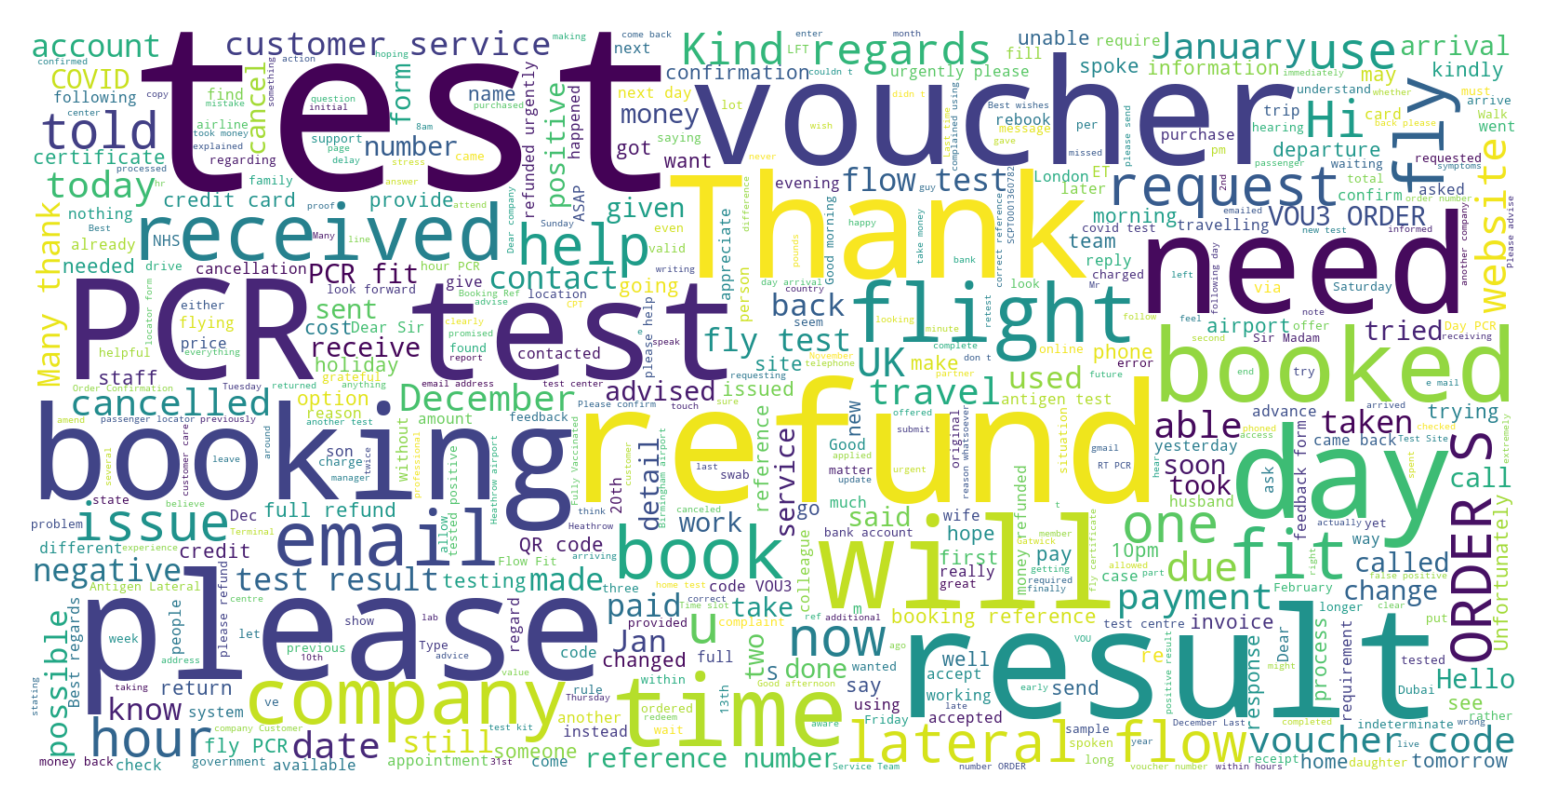

In [ ]:
from wordcloud import WordCloud

plt.figure(dpi=300)

text = df_final_results.sort_values("compound").query("compound > .6").body.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=250, max_words= 500, background_color="white",width=1600, height=800, 
                      random_state=1905).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the plot
plt.show()

Plot shows the average sentiment from 1st of january to the end of january. We notice that overal sentiment is positve however in the early january it is on its lowest and gradually starts 
to increase and by the middle of the month it is at highest.

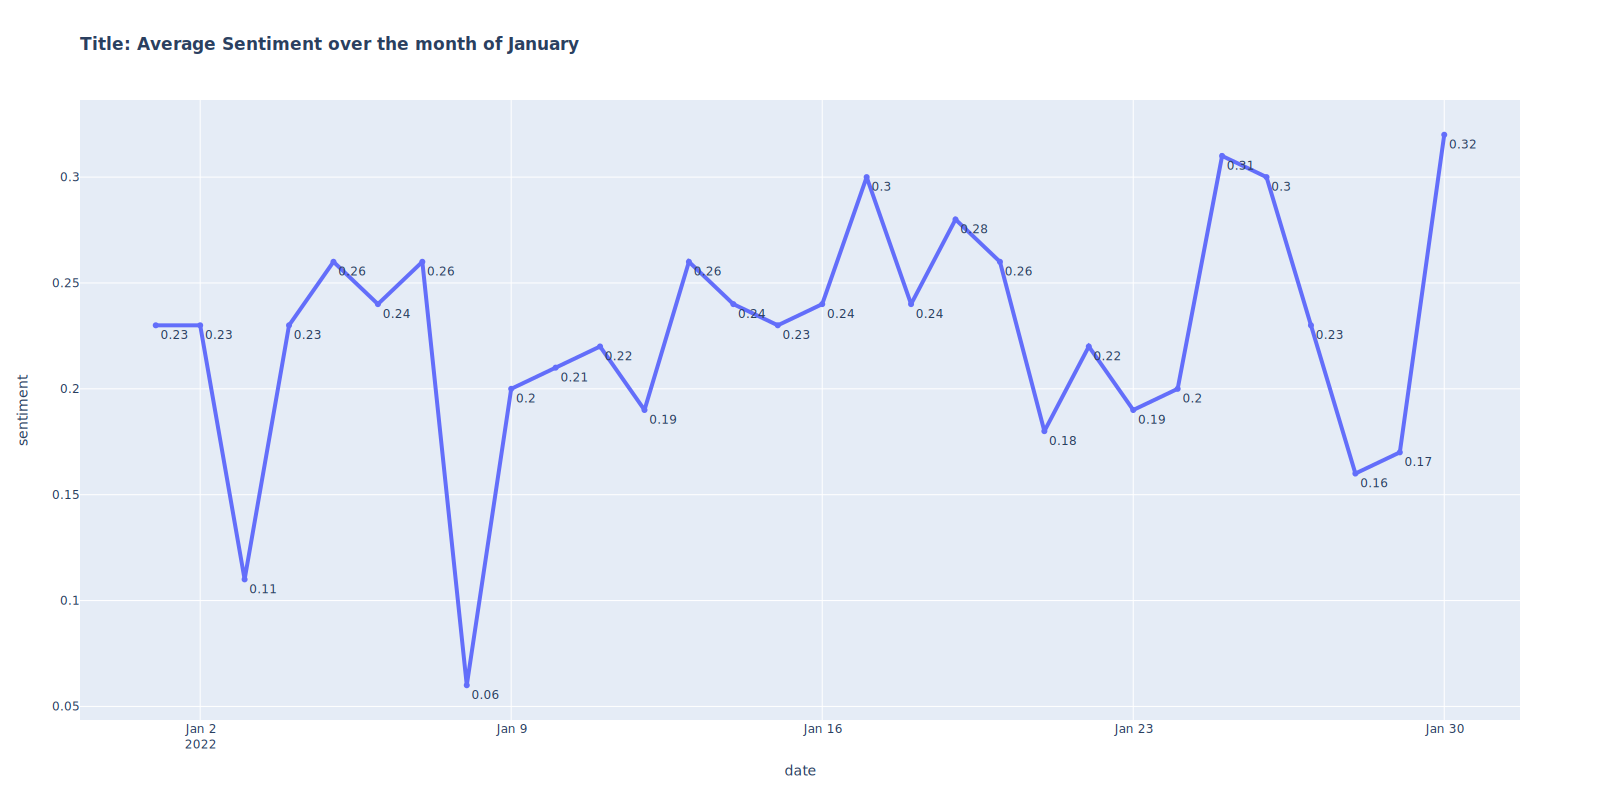

In [ ]:
pd.set_option( 'display.max_columns' , 150,'display.max_rows' , 100,'display.max_colwidth', 20)
(
    df_final_results.sort_values("compound")    
    .groupby("date", as_index=False).agg(sentiment= ("compound", "mean"))  
    .round(2)  
    .plot.line(x= "date", y = "sentiment", width= 1600, height = 800, text = "sentiment", 
               title= "<b> Title: Average Sentiment over the month of January </b>")
    .update_traces(textposition="bottom right", line= {"width":4})         
).show("svg")

Plot below shows the total number of positive, negative and neutral sentiment records
we see overall we have psotive sentiment with 1916 and negative records of 748 and neutral being 638

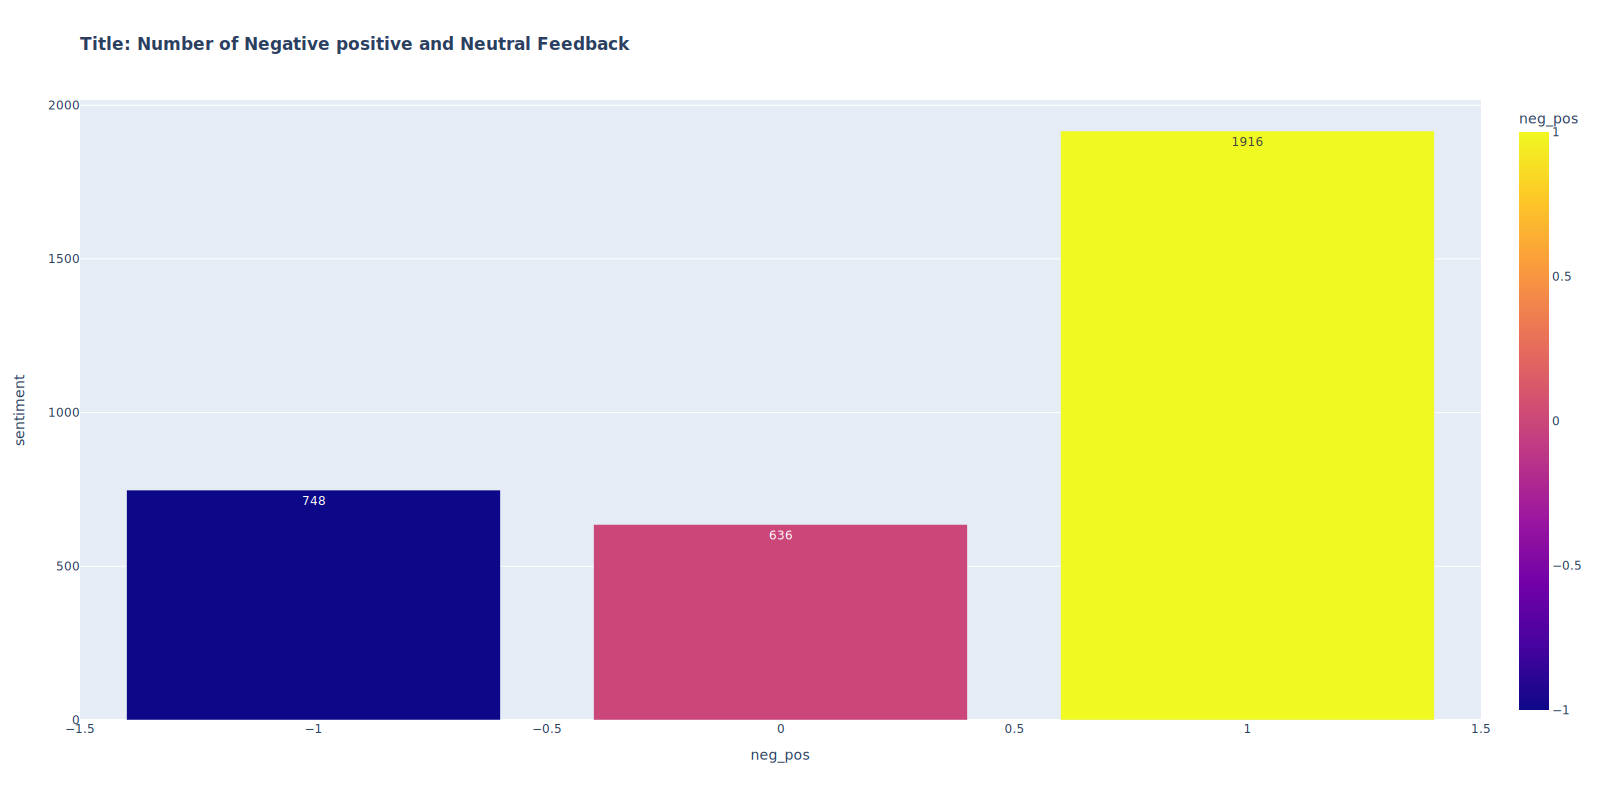

In [ ]:
(
    df_final_results.sort_values("compound")
    .assign(neg_pos= lambda df_: np.where(df_.compound < -.1, -1,
                                np.where(df_.compound > .1, 1 , 0))
            )
    .groupby("neg_pos", as_index=False).agg(sentiment= ("compound", "count"))    
.plot.bar(x= "neg_pos", y = "sentiment", color="neg_pos", text_auto = True, 
          width= 1600, height = 800,
          title= "<b> Title: Number of Negative positive and Neutral Feedback </b>"
          )
).show("svg")

plot showing the min, max and interquartile range of the scores

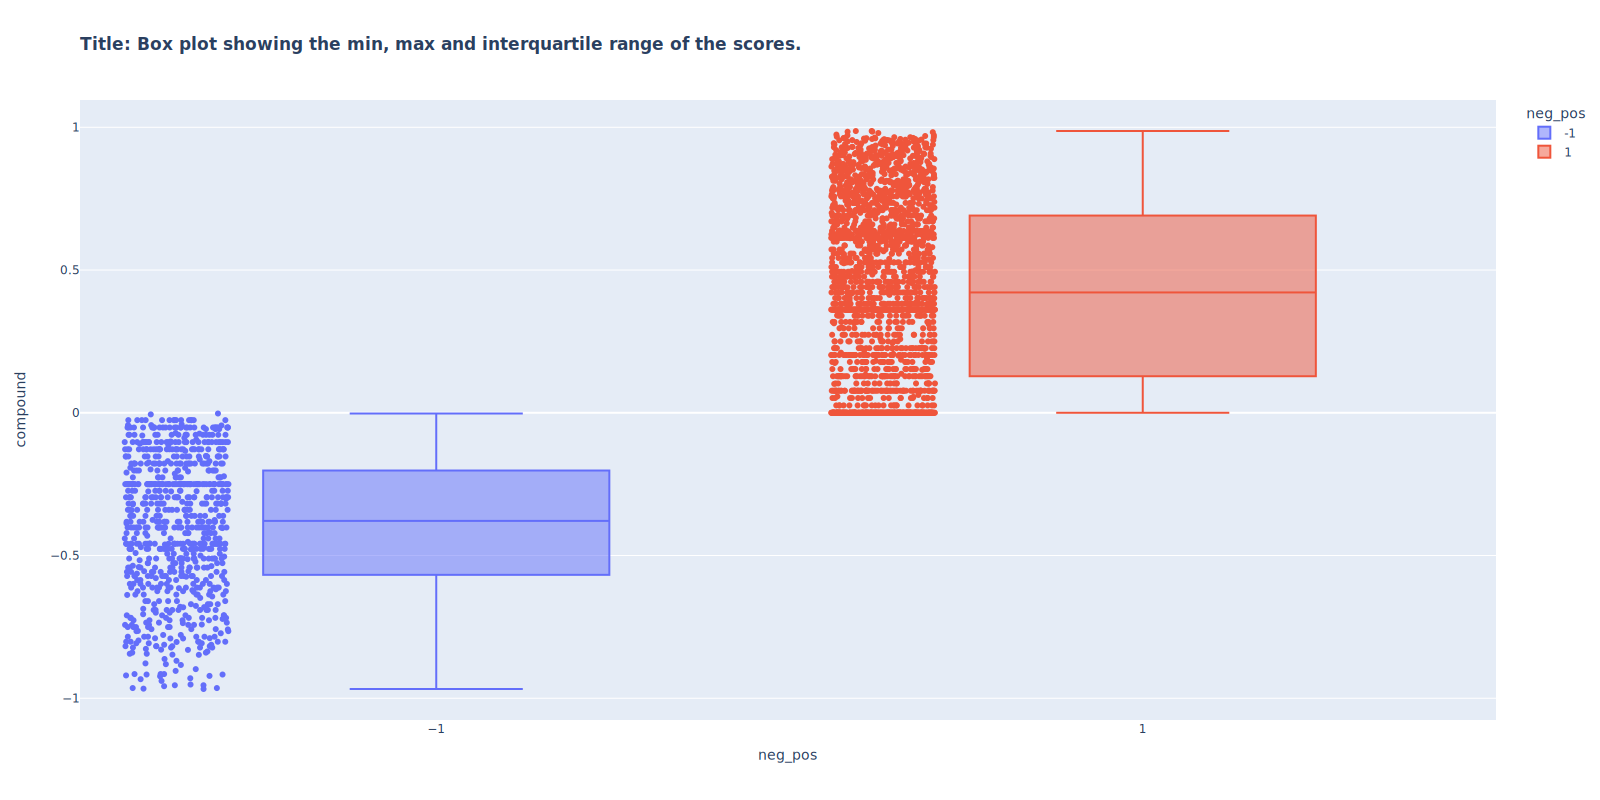

In [ ]:
(    df_final_results.sort_values("compound")
    .assign(neg_pos= lambda df_: np.where(df_.compound < -0, -1,
                                np.where(df_.compound >= 0, 1 , 0))
            )     
.plot.box(x= "neg_pos", y = "compound", color="neg_pos", 
          width= 1600, height = 800, points="all",
          title= "<b> Title: Box plot showing the min, max and interquartile range of the scores.</b>"          
          )
).show("svg")

## Results:

The analysis revealed that the majority of the feedback was negative. 

We found that customers were mainly complaining about issues related to the quality of the product or service.

The analysis also showed that there was a significant increase in negative feedback during a specific period, which may have been due to a change in the company's policies or practices.

## Conclusion

This analysis demonstrates the importance of sentiment analysis in understanding customer feedback. 

By using the NLTK sentiment analyzer and various preprocessing techniques, we were able to extract meaningful insights from the dataset. 

These insights can be used to improve the quality of the product or service and enhance customer satisfaction.